## Exon coverage for control data and simulated CNVs

In [1]:
import pysam
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from genepeeks.common import utilities as util
import seaborn as sns

%matplotlib inline

INFO:config:Using ini file set by environment: /Users/velina/Documents/GitHub/genepeeks-science/conf/genepeeks.ini
/Users/velina/.pyenv/versions/2.7.11/envs/dmd/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
DMD_ensembl = util.Mongo.get_collection_data('gene', wanted_db='prod', query={'_id': 'DMD'}, find_one=True, single_field='ensembl')
DMD_exons = util.get_nested_value(DMD_ensembl, ('is_primary', 'transcripts', 'is_primary', 'exons'))
# had to make local change in utilities 
DMD_exons_merged = util.merge_intervals(DMD_exons, min_dist=200, include_index=True)
exon_labels = ['Ex' + exon['index'] for exon in DMD_exons_merged]

Finished loading the gene collection from the genepeeks-prod database with a single entries with a query of {'_id': 'DMD'} after 10.28 sec


In [3]:
# DMD exon/gene coordinates and useful regions (coordinates taken from IGV b37 reference)
EXON46 = [31950197, 31950344]
EXON47 = [31947713, 31947862]
EXON48 = [31893308, 31893490]
EXON49 = [31854835, 31854939]
EXON50 = [31838092, 31838200]
EXON51 = [31792077, 31792309]
DMD = [31115794, 33357558]  # taken from ensembl GRCh37

# deletion of partial exons
EX48_50_PART = [31838130, 31893308]

# for consistency with exon labeling in Ensembl
exon_dict = {exon['index']: [exon['start'], exon['end']] for exon in DMD_exons_merged}
print exon_dict['1'][1] - exon_dict['1'][0]

2702


In [4]:
# Velina's local bam files for testing (names are consistent with subject/sample names)
bamfiles = ['FGPC-0000-444F.bam', 'FGPC-8V7M-82J3.bam', 'FPWB-0000-840T.bam', 'MGPC-6KHG-N0LS.bam']

In [5]:
# workaround to force real time print output in notebooks
# see http://stackoverflow.com/questions/29772158/make-ipython-notebook-print-in-real-time
import sys
oldsysstdout = sys.stdout
class flushfile():
    def __init__(self, f):
        self.f = f
    def __getattr__(self,name): 
        return object.__getattribute__(self.f, name)
    def write(self, x):
        self.f.write(x)
        self.f.flush()
    def flush(self):
        self.f.flush()
sys.stdout = flushfile(sys.stdout)

## Some exploration with exon length/coordinates

Exon 1 Coordinates: [31137345, 31140047]


(<matplotlib.text.Text at 0x10f37df50>, <matplotlib.text.Text at 0x10f8ac050>)

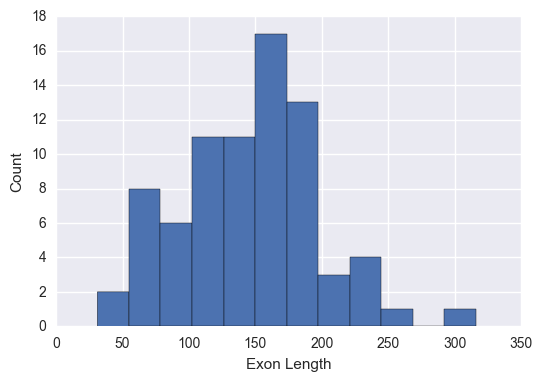

In [12]:
exon_lengths = [coord[1] - coord[0] for exon, coord in exon_dict.items() if exon != '1']
print 'Exon 1 Coordinates: {}'.format(exon_dict['1'])
plt.figure()
plt.hist(exon_lengths, bins=12)
plt.xlabel('Exon Length'), plt.ylabel('Count')

## Getting Stats from simulated deletion bams

In [7]:
file_path = 'bams/FGPC-0000-444F_49_del.bam'

In [37]:
# using Max's code to build coverage matrix from test subject bamfile
base_headers = ['subject', 'specimen', 'sample', 'gender', 'sequencer', 'flow_cell_id', 'lane']
coverage_matrix = [base_headers + exon_labels]
subject_coverages = {}
bamfile = pysam.AlignmentFile(file_path, "rb")
for RG in bamfile.header['RG']:
    subject, specimen_sample, flow_cell_lane = RG['ID'].split('_')
    gender = subject[0]
    specimen_num, sequencer, sample = specimen_sample.split('-')
    specimen = '{}_{}'.format(subject, specimen_num)
    sample = '{}_{}'.format(subject, specimen_sample)
    flow_cell_id, lane = flow_cell_lane.rsplit('-', 1)
    row = [subject, specimen, sample, gender, sequencer, flow_cell_id, lane]
    subject_coverages[RG['ID']] = row + [0] * len(DMD_exons_merged)

for read in bamfile.fetch('X', start=31137345, end=33229636):
    if not read.is_unmapped and read.mapping_quality == 60:
        # Find what exon each read falls in, and increase that exon's coverage by 1
        interval_info = util.in_interval(read.reference_start, DMD_exons_merged, get_interval=True)
        if not interval_info[0]:
            # If the start of the read is not in an exon, check the end of the read
            interval_info = util.in_interval(read.reference_end, DMD_exons_merged, get_interval=True)
        if interval_info[0]:
            exon_num = interval_info[1]
            subject_coverages[read.get_tag('RG')][exon_num + len(base_headers)] += 1

coverage_matrix += subject_coverages.values()
coverage_matrix = np.array(coverage_matrix)
#print coverage_matrix

In [9]:
single_sub = pd.DataFrame(coverage_matrix[1:], columns=coverage_matrix[0])
single_sub2 = single_sub.apply(lambda x: pd.to_numeric(x, errors='ignore'))
single_sub2.head()

,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,Ex1,Ex2,Ex3,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
0,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L004,519,25,116,...,163,73,161,108,210,109,57,123,31,120
1,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L002,609,22,161,...,179,64,176,115,181,98,55,160,33,149
2,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L003,533,20,111,...,160,60,186,102,227,92,54,134,25,131
3,FGPC-0000-444F,FGPC-0000-444F_1,FGPC-0000-444F_1-M1-1,F,M1,H5FGFAFXX,L001,605,36,148,...,157,60,206,124,229,85,67,159,48,152


In [10]:
single_grouped = single_sub2.groupby('subject').sum()
single_grouped.head()
single_norm = single_grouped.div(single_grouped.sum(axis=1),axis=0)
single_norm = single_norm.transpose().reset_index()
single_norm.rename(columns={'index': 'Exon'}, inplace=True)

## Pulling in control data (coverage data from previous runs)
Now we create a dataframe for coverage ratios from prior data -- we also subset the data on relevant variables like gender and sequencing panel (baits) to look for covariation and check for consistency. 

In [43]:
coverage_df = pd.read_csv('exon_data/coverage_matrix.csv', header=1, index_col=0)
coverage_df.index.name = None
coverage_df_f = coverage_df[coverage_df.gender == 'F']
coverage_df_m = coverage_df[coverage_df.gender == 'M']
coverage_df_RMA = coverage_df[coverage_df.subject.str.contains('FRMR')]
coverage_df_M1 = coverage_df[coverage_df.sequencer == 'M1']
coverage_df_M1_f = coverage_df_f[coverage_df_f.sequencer == 'M1']
coverage_df_T1_f = coverage_df_f[coverage_df_f.sequencer == 'T1']
coverage_df.head()

,id,subject,specimen,sample,gender,sequencer,flow_cell_id,lane,Ex1,Ex2,...,Ex70,Ex71,Ex72,Ex73,Ex74,Ex75,Ex76,Ex77,Ex78,Ex79
1,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L001,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L001,245,13,...,102,42,76,55,139,44,30,71,12,81
2,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L002,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L002,171,11,...,85,60,77,38,121,40,52,71,14,67
3,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L003,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L003,250,10,...,143,45,76,37,137,37,33,74,6,38
4,FCLR-GP01-2121_1-M1-1_HGGF5AFXX-L004,FCLR-GP01-2121,FCLR-GP01-2121_1,FCLR-GP01-2121_1-M1-1,F,M1,HGGF5AFXX,L004,208,16,...,152,32,96,51,117,29,32,79,9,56
5,FPWB-0000-429L_1-P1-1,FPWB-0000-429L,FPWB-0000-429L_1,FPWB-0000-429L_1-P1-1,F,P1,NaN,NaN,112,7,...,95,20,29,14,71,10,17,37,3,27


In [13]:
coverage_df.sequencer.unique()

array(['M1', 'P1', 'T1', 'T4', 'T3', 'T2'], dtype=object)

In [39]:
# function for reshaping data frames so that exons are observations (rows) and subjects are variables (columns)
def reshape_df(df, include_stats=False, subject_droplist=None):
    df_grouped = df.groupby(['subject']).sum()
    df_norm = df_grouped.div(df_grouped.sum(axis=1), axis=0)
    df_norm = df_norm.transpose().reset_index()
    df_norm.rename(columns={'index': 'Exon'}, inplace=True)

    if subject_droplist:
        for subject in subject_droplist:
            df_norm.drop(subject, axis=1, inplace=True)
    if include_stats:
        df_norm['Mean'] = df_norm.mean(axis=1)
        df_norm['SD'] = df_norm.std(axis=1)
    return df_norm


In [41]:
subjects_norm = reshape_df(coverage_df, include_stats=True, subject_droplist=['FGPC-0000-444F'])
subjects_norm.head()

subject,Exon,FB1E-0000-363X,FCLR-GP01-2121,FCLR-GP08-753E,FCLR-GP17-435H,FCLR-GP20-399A,FCLR-GP20-731O,FCLR-GP20-745F,FCLR-GP20-9287,FCLR-GP22-0112,...,MRMR-0060-736V,MRMR-0067-098S,MRMR-0070-091B,MRMR-0073-177W,MRMR-0076-691T,MRMR-0080-518T,MRMR-0080-829K,MRMR-0081-680Z,Mean,SD
0,Ex1,0.059294,0.034374,0.033821,0.031800,0.033895,0.032747,0.036952,0.032013,0.034607,...,0.049354,0.045395,0.047994,0.050132,0.042755,0.050702,0.043174,0.046565,0.043134,0.013242
1,Ex2,0.000589,0.001966,0.002029,0.001649,0.001520,0.001688,0.001338,0.001924,0.001323,...,0.000855,0.001605,0.001465,0.001353,0.001943,0.001974,0.001556,0.002119,0.001410,0.000573
2,Ex3,0.009367,0.011602,0.011076,0.010754,0.013817,0.013021,0.011487,0.012480,0.011536,...,0.013353,0.010088,0.008650,0.012627,0.011782,0.010377,0.011085,0.011655,0.011043,0.001302
3,Ex4,0.030897,0.018682,0.016699,0.015768,0.016769,0.016590,0.017253,0.017412,0.015339,...,0.018214,0.017425,0.014091,0.019617,0.017248,0.020360,0.018799,0.018961,0.018666,0.004090
4,Ex5,0.016871,0.009164,0.011922,0.010820,0.010240,0.012153,0.014070,0.015439,0.011536,...,0.011270,0.011922,0.009836,0.010222,0.011235,0.013197,0.011604,0.009034,0.012529,0.002551


In [46]:
male_norm = reshape_df(coverage_df_m, include_stats=True)
print male_norm.shape
male_norm.head()

(78, 17)


subject,Exon,MRMR-0011-266B,MRMR-0040-6444,MRMR-0047-446X,MRMR-0052-1169,MRMR-0052-358X,MRMR-0060-231F,MRMR-0060-736V,MRMR-0067-098S,MRMR-0070-091B,MRMR-0073-177W,MRMR-0076-691T,MRMR-0080-518T,MRMR-0080-829K,MRMR-0081-680Z,Mean,SD
0,Ex1,0.046895,0.044921,0.041482,0.059464,0.054014,0.048031,0.049354,0.045395,0.047994,0.050132,0.042755,0.050702,0.043174,0.046565,0.047920,0.004583
1,Ex2,0.001037,0.001732,0.001711,0.001893,0.001664,0.001488,0.000855,0.001605,0.001465,0.001353,0.001943,0.001974,0.001556,0.002119,0.001600,0.000340
2,Ex3,0.010119,0.011063,0.011279,0.012742,0.010659,0.011477,0.013353,0.010088,0.008650,0.012627,0.011782,0.010377,0.011085,0.011655,0.011211,0.001183
3,Ex4,0.018116,0.016873,0.016785,0.019621,0.018754,0.017268,0.018214,0.017425,0.014091,0.019617,0.017248,0.020360,0.018799,0.018961,0.018009,0.001523
4,Ex5,0.009922,0.013130,0.009034,0.012096,0.013447,0.010626,0.011270,0.011922,0.009836,0.010222,0.011235,0.013197,0.011604,0.009034,0.011184,0.001425


In [44]:
fem_norm = reshape_df(coverage_df_f, include_stats=True)
fem_norm.head()

subject,Exon,FB1E-0000-363X,FCLR-GP01-2121,FCLR-GP08-753E,FCLR-GP17-435H,FCLR-GP20-399A,FCLR-GP20-731O,FCLR-GP20-745F,FCLR-GP20-9287,FCLR-GP22-0112,...,FRMR-00MS-704S,FRMR-00NC-7632,FRMR-00SA-876L,FRMR-00SB-851W,FRMR-00SC-714V,FRMR-00SD-679G,FRMR-00ST-841F,FRMR-00TS-8464,Mean,SD
0,Ex1,0.059294,0.034374,0.033821,0.031800,0.033895,0.032747,0.036952,0.032013,0.034607,...,0.047474,0.049913,0.041827,0.043412,0.047473,0.040683,0.049380,0.044282,0.042530,0.013788
1,Ex2,0.000589,0.001966,0.002029,0.001649,0.001520,0.001688,0.001338,0.001924,0.001323,...,0.001696,0.001457,0.001612,0.001898,0.001795,0.002227,0.002079,0.001681,0.001391,0.000592
2,Ex3,0.009367,0.011602,0.011076,0.010754,0.013817,0.013021,0.011487,0.012480,0.011536,...,0.011040,0.010678,0.011174,0.011885,0.010244,0.009834,0.012735,0.011960,0.011015,0.001310
3,Ex4,0.030897,0.018682,0.016699,0.015768,0.016769,0.016590,0.017253,0.017412,0.015339,...,0.020950,0.020907,0.018906,0.017222,0.018785,0.015447,0.021608,0.020530,0.018732,0.004288
4,Ex5,0.016871,0.009164,0.011922,0.010820,0.010240,0.012153,0.014070,0.015439,0.011536,...,0.010690,0.009108,0.011037,0.010289,0.010058,0.011319,0.011138,0.010895,0.012690,0.002603


We're interested in how well exon coverage ratios correlate across different subsets of data -- for example between genders. The plot below that that there is correlation but it is not very high.

(<matplotlib.text.Text at 0x117f3b250>, <matplotlib.text.Text at 0x1190d44d0>)

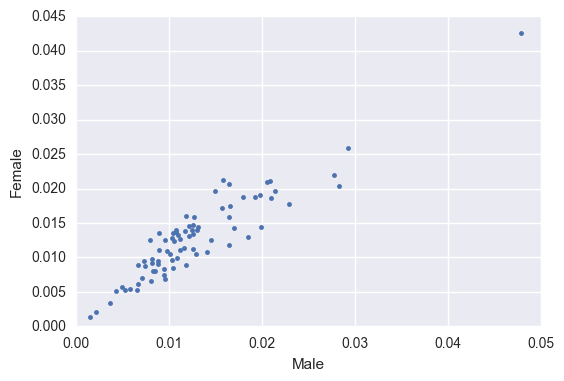

In [45]:
plt.figure()
plt.plot(male_norm.Mean, fem_norm.Mean, '.')
plt.xlabel('Male'), plt.ylabel('Female')

(array([ 17.,  23.,  16.,   7.,   9.,   4.,   1.,   0.,   0.,   1.]),
 array([ 0.00059212,  0.00191172,  0.00323132,  0.00455092,  0.00587052,
         0.00719012,  0.00850972,  0.00982932,  0.01114892,  0.01246852,
         0.01378812]),
 <a list of 10 Patch objects>)

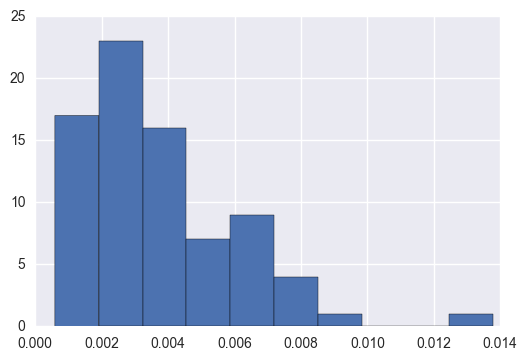

In [26]:
plt.figure()
plt.hist(fem_norm.SD)

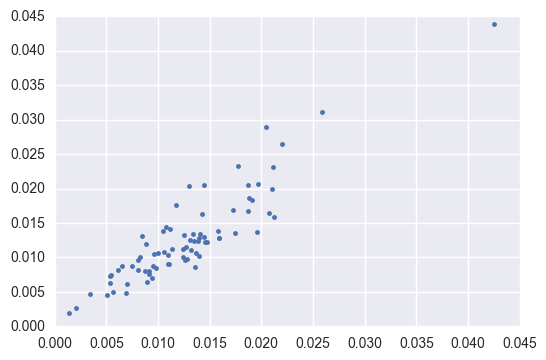

In [27]:
plt.figure()
plt.plot(fem_norm.Mean, single_norm['FGPC-0000-444F'], '.')

In [28]:
# this is only the females in RMA
coverage_df_RMA = reshape_df(coverage_df_RMA, include_stats=True)

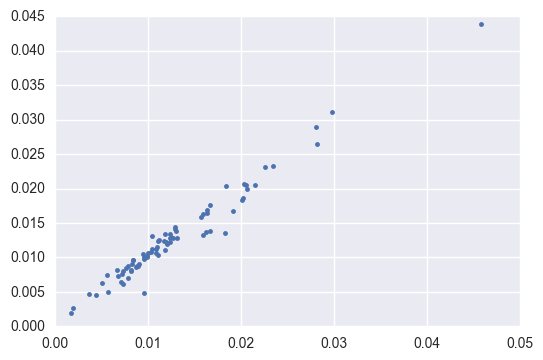

In [29]:
plt.figure()
plt.plot(coverage_df_RMA.Mean, single_norm['FGPC-0000-444F'], '.')

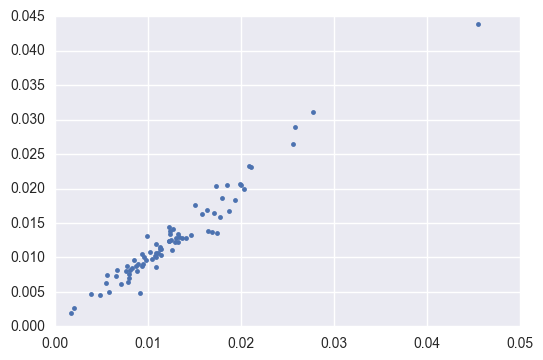

In [30]:
control_M1_f = reshape_df(coverage_df_M1_f, include_stats=True)
plt.figure()
plt.plot(control_M1_f.Mean, single_norm['FGPC-0000-444F'], '.')

(<matplotlib.text.Text at 0x117790ed0>, <matplotlib.text.Text at 0x1177a1410>)

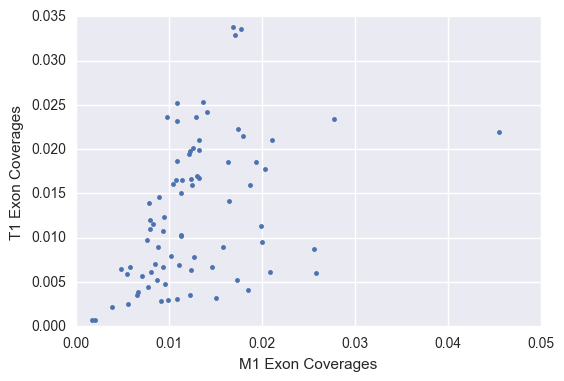

In [31]:
control_T1_f = reshape_df(coverage_df_T1_f, include_stats=True)
plt.figure()
plt.plot(control_M1_f.Mean, control_T1_f.Mean, '.')
plt.xlabel('M1 Exon Coverages'), plt.ylabel('T1 Exon Coverages')

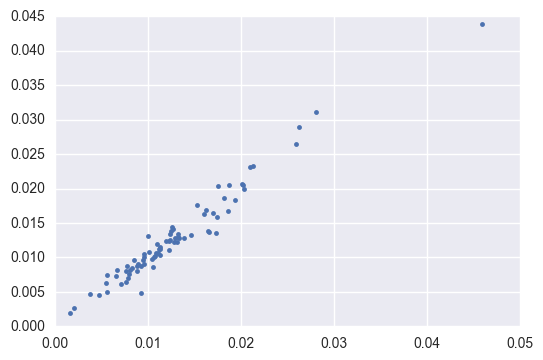

In [32]:
control_M1 = reshape_df(coverage_df_M1, include_stats=True)
plt.figure()
plt.plot(control_M1.Mean, single_norm['FGPC-0000-444F'], '.')

In [33]:
control_M1.head()

subject,Exon,FCLR-GP01-2121,FCLR-GP08-753E,FCLR-GP17-435H,FCLR-GP20-399A,FCLR-GP20-731O,FCLR-GP20-745F,FCLR-GP20-9287,FCLR-GP22-0112,FCLR-NA01-2121,...,MRMR-0060-736V,MRMR-0067-098S,MRMR-0070-091B,MRMR-0073-177W,MRMR-0076-691T,MRMR-0080-518T,MRMR-0080-829K,MRMR-0081-680Z,Mean,SD
0,Ex1,0.034374,0.033821,0.031800,0.033895,0.032747,0.036952,0.032013,0.034607,0.037048,...,0.049354,0.045395,0.047994,0.050132,0.042755,0.050702,0.043174,0.046565,0.045945,0.006635
1,Ex2,0.001966,0.002029,0.001649,0.001520,0.001688,0.001338,0.001924,0.001323,0.001632,...,0.000855,0.001605,0.001465,0.001353,0.001943,0.001974,0.001556,0.002119,0.001703,0.000380
2,Ex3,0.011602,0.011076,0.010754,0.013817,0.013021,0.011487,0.012480,0.011536,0.010981,...,0.013353,0.010088,0.008650,0.012627,0.011782,0.010377,0.011085,0.011655,0.011360,0.000999
3,Ex4,0.018682,0.016699,0.015768,0.016769,0.016590,0.017253,0.017412,0.015339,0.014592,...,0.018214,0.017425,0.014091,0.019617,0.017248,0.020360,0.018799,0.018961,0.018618,0.002975
4,Ex5,0.009164,0.011922,0.010820,0.010240,0.012153,0.014070,0.015439,0.011536,0.012663,...,0.011270,0.011922,0.009836,0.010222,0.011235,0.013197,0.011604,0.009034,0.011328,0.001320


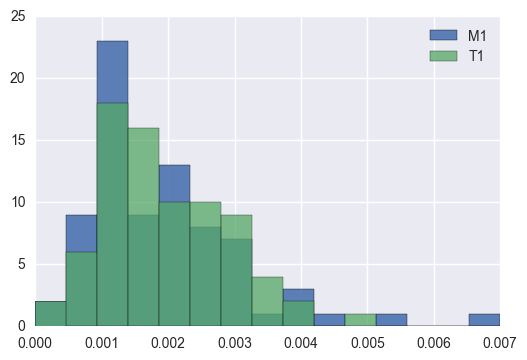

In [34]:
plt.figure()
plt.hist(control_M1_f.SD, label='M1', bins=15, range=(0, 0.007), alpha=0.9)
plt.hold(True), 
plt.hist(control_T1_f.SD, label='T1', bins=15, range=(0, 0.007), alpha=0.75)
plt.legend()

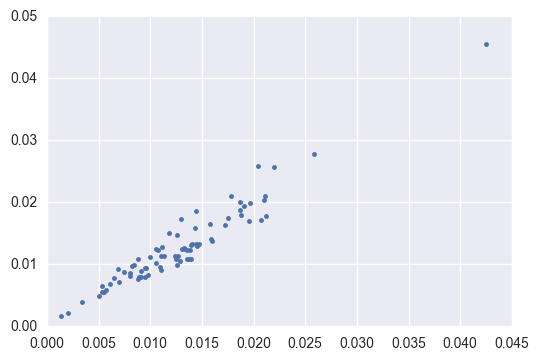

In [35]:
plt.figure()
plt.plot(fem_norm.Mean, control_M1_f.Mean, '.')

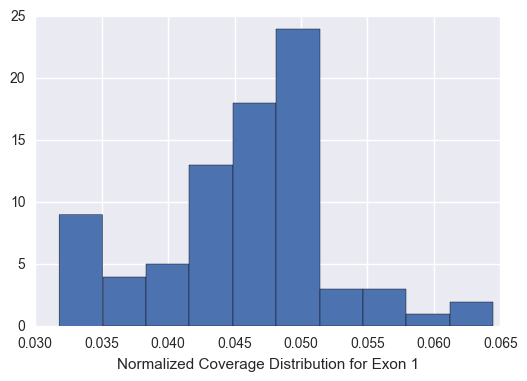

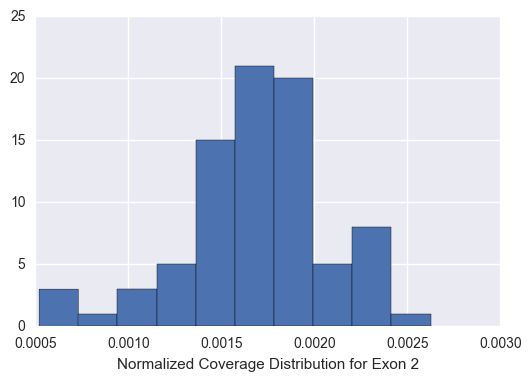

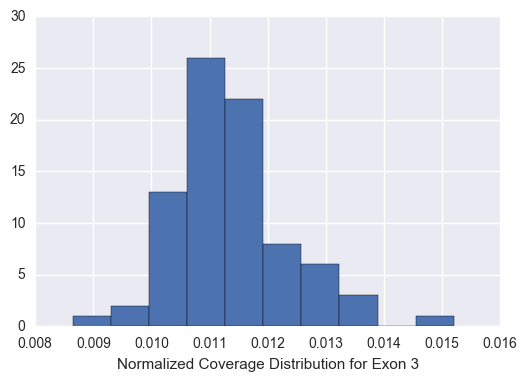

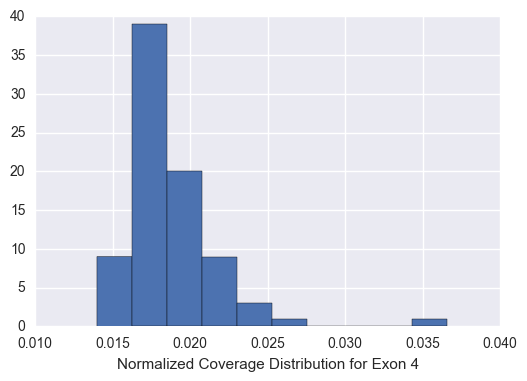

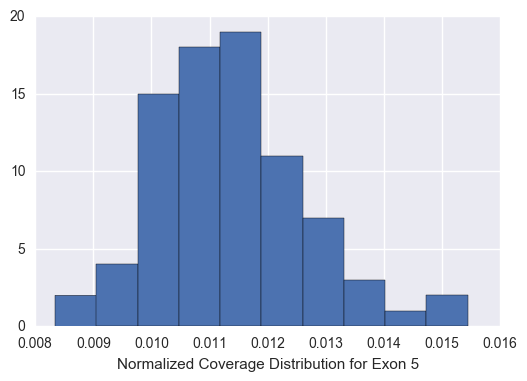

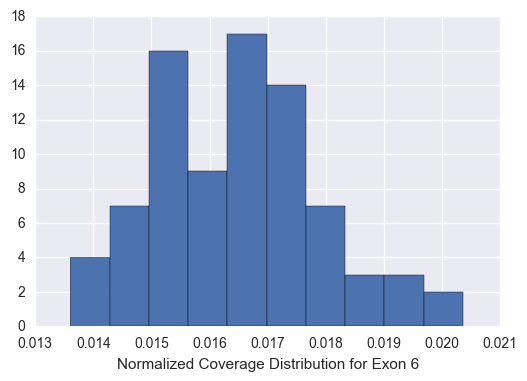

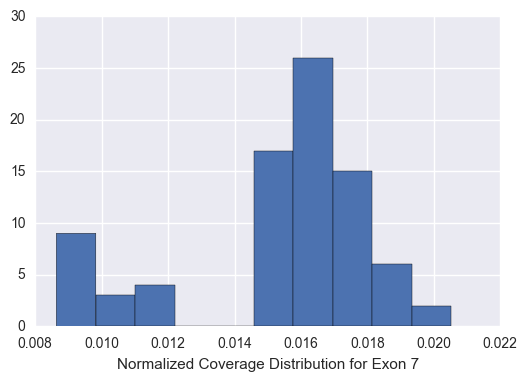

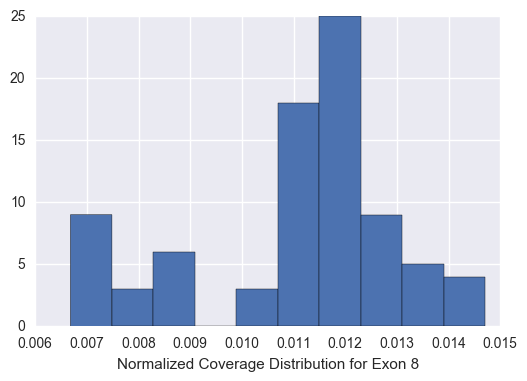

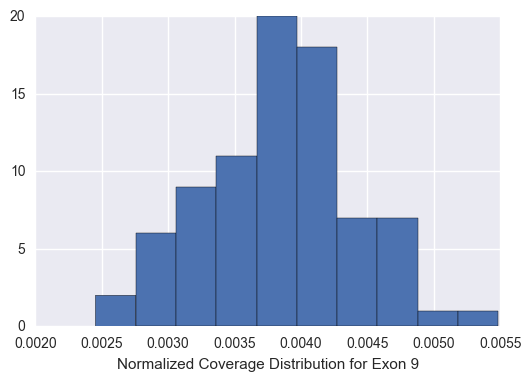

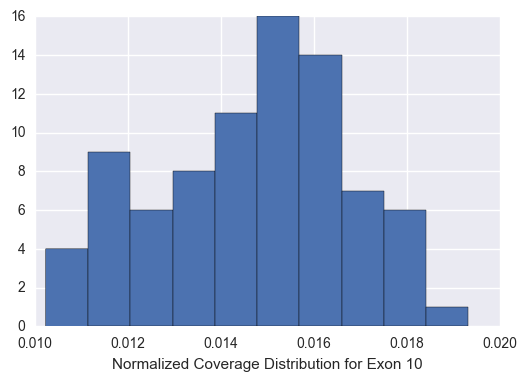

In [36]:
for i in range(10):
    plt.figure()
    plt.hist(control_M1.ix[i][1:-3])
    plt.xlabel('Normalized Coverage Distribution for Exon {}'.format(i+1))